# Exploración y reestructuración de datos

Realizamos la reestructura del dataset de Eventos de Violencia con Armas, generando nuevos campos a partir de los originales con la finalidad de que esto nos permita encontrar otros tipos de relaciones y correlaciones. 

A partir de las correlaciones haremos la prueba de entrenar un modelo de regresión lineal simple o múltiple, según la necesidad, con el fin de validar luego el rendimiento del mismo. 

In [1]:
#importando librerias necesarias
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os

#importando datos
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Proyecto DSCH/gun_violence'
gun_violence = pd.read_csv('gun_violence_data.csv')

Mounted at /content/gdrive
/content/gdrive/MyDrive/Proyecto DSCH/gun_violence


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
# Transformando la fecha en columnas individuales
gun_violence['date'] = pd.to_datetime(gun_violence['date'])
gun_violence['day'] = gun_violence['date'].dt.day
gun_violence['month'] = gun_violence['date'].dt.month
gun_violence['year'] = gun_violence['date'].dt.year
gun_violence['day_of_the_week'] = gun_violence['date'].dt.dayofweek


In [3]:
#Eliminando outliers y limitando las fechas

#gun_violence=gun_violence.dropna(subset=['n_guns_involved'])
gun_violence=gun_violence.drop(['congressional_district','state_senate_district', 'state_house_district'], axis=1)
gun_violence = gun_violence.drop(gun_violence[gun_violence.year <= 2013].index)
gun_violence = gun_violence.drop(gun_violence[gun_violence.year >= 2018].index)
gun_violence = gun_violence.drop(gun_violence[gun_violence.n_guns_involved > 20].index)
gun_violence = gun_violence.drop(gun_violence[gun_violence.n_killed >= 10].index)

#Factorizando estados y ciudades
gun_violence['state_n'] = pd.factorize(gun_violence['state'])[0] + 1
gun_violence['city_n'] = pd.factorize(gun_violence['city_or_county'])[0] + 1

In [4]:
#Funciones para separar datos de columnas individuales a múltiples

def attr_split(attr):
  return attr.split('||')

def attr_parse(attr):
  if attr.__contains__('::'): return attr.split('::')
  elif attr.__contains__(':'): return attr.split(':')

  return None

def parse(attr):
  items = [None] * 20
  if (attr != attr): return items

  if attr.__contains__('||'):
    splited = attr_split(attr)
    for x in splited:
      string = attr_parse(x)
      try:
        if int(string[0]) >= 20: break
      except:
        return items

      if string is not None: items[int(string[0])] = string[1]
  else:
    string = attr_parse(attr)
    if string is not None: items[int(string[0])] = string[1]
    
  return items

def parse2(attr):
  if attr != attr: return []
  elif len(attr) == 0: return []
  elif attr.__contains__('||'): return attr_split(attr)
  else: return [attr]

def participant_type(arr, participant_type, is_victim, sum_variable):
  total = 0
  for i in range(0,20):
    if is_victim:
      if participant_type[i] != 'Victim': continue
    else:
      if participant_type[i] != 'Subject-Suspect': continue

    if sum_variable == arr[i]: total += 1

  return total

In [5]:
#data['FirstName'] = data['EmployeeName'].apply(lambda x : x.split()[0])

for index, row in gun_violence.iterrows():
  gun_violence.at[index,'gun_stolen'] = parse(gun_violence['gun_stolen'][index])
  gun_violence.at[index,'gun_type'] = parse(gun_violence['gun_type'][index])
  gun_violence.at[index,'incident_characteristics'] = parse2(gun_violence['incident_characteristics'][index])
  gun_violence.at[index,'participant_age'] = parse(gun_violence['participant_age'][index])
  gun_violence.at[index,'participant_age_group'] = parse(gun_violence['participant_age_group'][index])
  gun_violence.at[index,'participant_gender'] = parse(gun_violence['participant_gender'][index])
  gun_violence.at[index,'participant_status'] = parse(gun_violence['participant_status'][index])
  gun_violence.at[index,'participant_type'] = parse(gun_violence['participant_type'][index])

In [6]:
#gun_violence['gun_stolen'] = gun_violence['gun_stolen'].apply(parse)
#gun_violence['gun_type'] = gun_violence['gun_type'].apply(parse)
#gun_violence['incident_characteristics'] = gun_violence['incident_characteristics'].apply(parse2)
#gun_violence['participant_age'] = gun_violence['participant_age'].apply(parse)
#gun_violence['participant_age_group'] = gun_violence['participant_age_group'].apply(parse)
#gun_violence['participant_gender'] = gun_violence['participant_gender'].apply(parse)
#gun_violence['participant_status'] = gun_violence['participant_status'].apply(parse)
#gun_violence['participant_type'] = gun_violence['participant_type'].apply(parse)

In [7]:
#guardado del Dataframe como .tsv
gun_violence.to_csv("gun_violence.tsv", sep="\t")

In [8]:
gun_violence.head()

,incident_id,date,state,city_or_county,n_killed,n_injured,gun_stolen,gun_type,incident_characteristics,latitude,...,participant_age_group,participant_gender,participant_status,participant_type,day,month,year,day_of_the_week,state_n,city_n
0,92114,2014-01-01,Kentucky,Lexington,0,1,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[Shot - Wounded/Injured],38.0507,...,"[Adult 18+, None, None, None, None, None, None...","[Male, None, None, None, None, None, None, Non...","[Injured, None, None, None, None, None, None, ...","[Victim, None, None, None, None, None, None, N...",1,1,2014,2,1,1
1,92117,2014-01-01,Kentucky,Cynthiana,0,1,"[Unknown, None, None, None, None, None, None, ...","[Unknown, None, None, None, None, None, None, ...","[Shot - Wounded/Injured, Accidental Shooting, ...",38.4333,...,"[Adult 18+, Adult 18+, None, None, None, None,...","[Male, Male, None, None, None, None, None, Non...","[Injured, Unharmed, Arrested, None, None, None...","[Victim, Subject-Suspect, None, None, None, No...",1,1,2014,2,1,2
2,92119,2014-01-01,Kentucky,Louisville,0,1,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[Shot - Wounded/Injured],38.2501,...,"[Adult 18+, None, None, None, None, None, None...","[Male, None, None, None, None, None, None, Non...","[Injured, None, None, None, None, None, None, ...","[Victim, None, None, None, None, None, None, N...",1,1,2014,2,1,3
3,92125,2014-01-01,Oklahoma,Lawton,0,0,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[Shots Fired - No Injuries],34.6347,...,"[Adult 18+, None, None, None, None, None, None...","[Male, Male, None, None, None, None, None, Non...","[Unharmed, Unharmed, None, None, None, None, N...","[Victim, Subject-Suspect, None, None, None, No...",1,1,2014,2,2,4
4,92131,2014-01-01,New York,Bronx,0,1,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[Pistol-whipping],40.8179,...,"[Adult 18+, None, None, None, None, None, None...","[Male, None, None, None, None, None, None, Non...","[Injured, None, None, None, None, None, None, ...","[Victim, None, None, None, None, None, None, N...",1,1,2014,2,3,5


In [9]:
gun_violence.describe()

,incident_id,n_killed,n_injured,latitude,longitude,n_guns_involved,day,month,year,day_of_the_week,state_n,city_n
count,1.742330e+05,174233.000000,174233.000000,174233.000000,174233.000000,96298.000000,174233.000000,174233.000000,174233.000000,174233.000000,174233.000000,174233.000000
mean,5.258009e+05,0.297975,0.550057,37.556478,-89.114577,1.204823,15.772540,6.496140,2015.570764,3.068242,19.095849,1376.521807
std,2.761066e+05,0.536401,0.725969,5.116889,14.339513,1.045732,8.847155,3.369285,1.121268,2.023631,12.755438,2296.503246
min,9.211400e+04,0.000000,0.000000,19.111400,-171.429000,1.000000,1.000000,1.000000,2014.000000,0.000000,1.000000,1.000000
25%,2.924840e+05,0.000000,0.000000,33.903900,-93.272000,1.000000,8.000000,4.000000,2015.000000,1.000000,8.000000,74.000000
50%,5.096000e+05,0.000000,0.000000,38.613600,-86.133700,1.000000,16.000000,7.000000,2016.000000,3.000000,15.000000,304.000000
75%,7.726430e+05,1.000000,1.000000,41.468500,-79.896800,1.000000,23.000000,9.000000,2017.000000,5.000000,31.000000,1472.000000
max,1.083162e+06,9.000000,25.000000,71.336800,-67.271100,20.000000,31.000000,12.000000,2017.000000,6.000000,51.000000,11579.000000


In [10]:
#inicializando nuevas columnas
gun_violence['participant_male'] = 0
gun_violence['participant_female'] = 0
gun_violence['participant_child'] = 0
gun_violence['participant_teen'] = 0
gun_violence['participant_adult'] = 0
gun_violence['participant_injured'] = 0
gun_violence['participant_injured_arrested'] = 0
gun_violence['participant_unharmed'] = 0
gun_violence['participant_unharmed_arrested'] = 0
gun_violence['participant_killed'] = 0
gun_violence['participant_victim'] = 0
gun_violence['participant_subject_suspect'] = 0


gun_violence['participant_victim_male'] = 0
gun_violence['participant_victim_female'] = 0
gun_violence['participant_victim_child'] = 0
gun_violence['participant_victim_teen'] = 0
gun_violence['participant_victim_adult'] = 0
gun_violence['participant_victim_injured'] = 0
gun_violence['participant_victim_injured_arrested'] = 0
gun_violence['participant_victim_unharmed'] = 0
gun_violence['participant_victim_unharmed_arrested'] = 0
gun_violence['participant_victim_killed'] = 0
gun_violence['participant_suspect_male'] = 0
gun_violence['participant_suspect_female'] = 0
gun_violence['participant_suspect_child'] = 0
gun_violence['participant_suspect_teen'] = 0
gun_violence['participant_suspect_adult'] = 0
gun_violence['participant_suspect_injured'] = 0
gun_violence['participant_suspect_injured_arrested'] = 0
gun_violence['participant_suspect_unharmed'] = 0
gun_violence['participant_suspect_unharmed_arrested'] = 0
gun_violence['participant_suspect_killed'] = 0



In [11]:
#Separación de los datos en las columnas inicializadas

for index, row in gun_violence.iterrows():
  gun_violence.at[index,'participant_male'] = gun_violence.at[index,'participant_gender'].count('Male')
  gun_violence.at[index,'participant_female'] = gun_violence.at[index,'participant_gender'].count('Female')
  gun_violence.at[index,'participant_child'] = gun_violence.at[index,'participant_age_group'].count('Child 0-11')
  gun_violence.at[index,'participant_teen'] = gun_violence.at[index,'participant_age_group'].count('Teen 12-17')
  gun_violence.at[index,'participant_adult'] = gun_violence.at[index,'participant_age_group'].count('Adult 18+')
  gun_violence.at[index,'participant_injured'] = gun_violence.at[index,'participant_status'].count('Injured')
  gun_violence.at[index,'participant_injured_arrested'] = gun_violence.at[index,'participant_status'].count('Injured, Arrested')
  gun_violence.at[index,'participant_unharmed'] = gun_violence.at[index,'participant_status'].count('Unharmed')
  gun_violence.at[index,'participant_unharmed_arrested'] = gun_violence.at[index,'participant_status'].count('Unharmed, Arrested')
  gun_violence.at[index,'participant_killed'] = gun_violence.at[index,'participant_status'].count('Killed')
  gun_violence.at[index,'participant_victim'] = gun_violence.at[index,'participant_type'].count('Victim')
  gun_violence.at[index,'participant_subject_suspect'] = gun_violence.at[index,'participant_type'].count('Subject-Suspect')


  gun_violence.at[index,'participant_victim_male'] = participant_type(gun_violence.at[index,'participant_gender'], gun_violence.at[index,'participant_type'], True, 'Male')
  gun_violence.at[index,'participant_victim_female'] = participant_type(gun_violence.at[index,'participant_gender'], gun_violence.at[index,'participant_type'], True, 'Female')
  gun_violence.at[index,'participant_victim_child'] = participant_type(gun_violence.at[index,'participant_age_group'], gun_violence.at[index,'participant_type'], True, 'Child 0-11')
  gun_violence.at[index,'participant_victim_teen'] = participant_type(gun_violence.at[index,'participant_age_group'], gun_violence.at[index,'participant_type'], True, 'Teen 12-17')
  gun_violence.at[index,'participant_victim_adult'] = participant_type(gun_violence.at[index,'participant_age_group'], gun_violence.at[index,'participant_type'], True, 'Adult 18+')
  gun_violence.at[index,'participant_victim_injured'] = participant_type(gun_violence.at[index,'participant_status'], gun_violence.at[index,'participant_type'], True, 'Injured')
  gun_violence.at[index,'participant_victim_injured_arrested'] = participant_type(gun_violence.at[index,'participant_status'], gun_violence.at[index,'participant_type'], True, 'Injured, Arrested')
  gun_violence.at[index,'participant_victim_unharmed'] = participant_type(gun_violence.at[index,'participant_status'], gun_violence.at[index,'participant_type'], True, 'Unharmed')
  gun_violence.at[index,'participant_victim_unharmed_arrested'] = participant_type(gun_violence.at[index,'participant_status'], gun_violence.at[index,'participant_type'], True, 'Unharmed, Arrested')
  gun_violence.at[index,'participant_victim_killed'] = participant_type(gun_violence.at[index,'participant_status'], gun_violence.at[index,'participant_type'], True, 'Killed')
  gun_violence.at[index,'participant_suspect_male'] = participant_type(gun_violence.at[index,'participant_gender'], gun_violence.at[index,'participant_type'], False, 'Male')
  gun_violence.at[index,'participant_suspect_female'] = participant_type(gun_violence.at[index,'participant_gender'], gun_violence.at[index,'participant_type'], False, 'Female')
  gun_violence.at[index,'participant_suspect_child'] = participant_type(gun_violence.at[index,'participant_age_group'], gun_violence.at[index,'participant_type'], False, 'Child 0-11')
  gun_violence.at[index,'participant_suspect_teen'] = participant_type(gun_violence.at[index,'participant_age_group'], gun_violence.at[index,'participant_type'], False, 'Teen 12-17')
  gun_violence.at[index,'participant_suspect_adult'] = participant_type(gun_violence.at[index,'participant_age_group'], gun_violence.at[index,'participant_type'], False, 'Adult 18+')
  gun_violence.at[index,'participant_suspect_injured'] = participant_type(gun_violence.at[index,'participant_status'], gun_violence.at[index,'participant_type'], False, 'Injured')
  gun_violence.at[index,'participant_suspect_injured_arrested'] = participant_type(gun_violence.at[index,'participant_status'], gun_violence.at[index,'participant_type'], False, 'Injured, Arrested')
  gun_violence.at[index,'participant_suspect_unharmed'] = participant_type(gun_violence.at[index,'participant_status'], gun_violence.at[index,'participant_type'], False, 'Unharmed')
  gun_violence.at[index,'participant_suspect_unharmed_arrested'] = participant_type(gun_violence.at[index,'participant_status'], gun_violence.at[index,'participant_type'], False, 'Unharmed, Arrested')
  gun_violence.at[index,'participant_suspect_killed'] = participant_type(gun_violence.at[index,'participant_status'], gun_violence.at[index,'participant_type'], False, 'Killed')

In [13]:
gun_violence

,incident_id,date,state,city_or_county,n_killed,n_injured,gun_stolen,gun_type,incident_characteristics,latitude,...,participant_suspect_male,participant_suspect_female,participant_suspect_child,participant_suspect_teen,participant_suspect_adult,participant_suspect_injured,participant_suspect_injured_arrested,participant_suspect_unharmed,participant_suspect_unharmed_arrested,participant_suspect_killed
0,92114,2014-01-01,Kentucky,Lexington,0,1,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[Shot - Wounded/Injured],38.0507,...,0,0,0,0,0,0,0,0,0,0
1,92117,2014-01-01,Kentucky,Cynthiana,0,1,"[Unknown, None, None, None, None, None, None, ...","[Unknown, None, None, None, None, None, None, ...","[Shot - Wounded/Injured, Accidental Shooting, ...",38.4333,...,1,0,0,0,1,0,0,0,1,0
2,92119,2014-01-01,Kentucky,Louisville,0,1,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[Shot - Wounded/Injured],38.2501,...,0,0,0,0,0,0,0,0,0,0
3,92125,2014-01-01,Oklahoma,Lawton,0,0,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[Shots Fired - No Injuries],34.6347,...,1,0,0,0,0,0,0,1,0,0
4,92131,2014-01-01,New York,Bronx,0,1,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[Pistol-whipping],40.8179,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184061,1080683,2016-06-01,Kansas,Hamilton (county),0,0,"[Stolen, None, None, None, None, None, None, N...","[9mm, None, None, None, None, None, None, None...","[Non-Shooting Incident, Officer Involved Incid...",37.9570,...,1,0,0,0,1,0,0,0,1,0
184077,1080779,2017-09-22,Florida,Pensacola,0,1,"[Unknown, None, None, None, None, None, None, ...","[Handgun, None, None, None, None, None, None, ...","[Shot - Wounded/Injured, Domestic Violence, Br...",30.4260,...,1,0,0,0,1,0,0,0,1,0
184095,1081083,2016-07-01,Pennsylvania,Washington,0,0,"[Unknown, None, None, None, None, None, None, ...","[Unknown, None, None, None, None, None, None, ...","[Institution/Group/Business, Non-Shooting Inci...",40.1732,...,1,0,0,0,1,0,0,0,1,0
184227,1082063,2017-09-03,Massachusetts,Boston,0,0,"[Unknown, None, None, None, None, None, None, ...","[Unknown, None, None, None, None, None, None, ...","[Non-Shooting Incident, Brandishing/flourishin...",42.3447,...,1,0,0,0,1,0,0,0,1,0


# Visualizaciones

Graficamos el dataset resultante de los cambios y ajustes para testear diferentes variables y sus relaciones

Text(0.5, 1.0, 'Participantes por grupo etáreo por año')

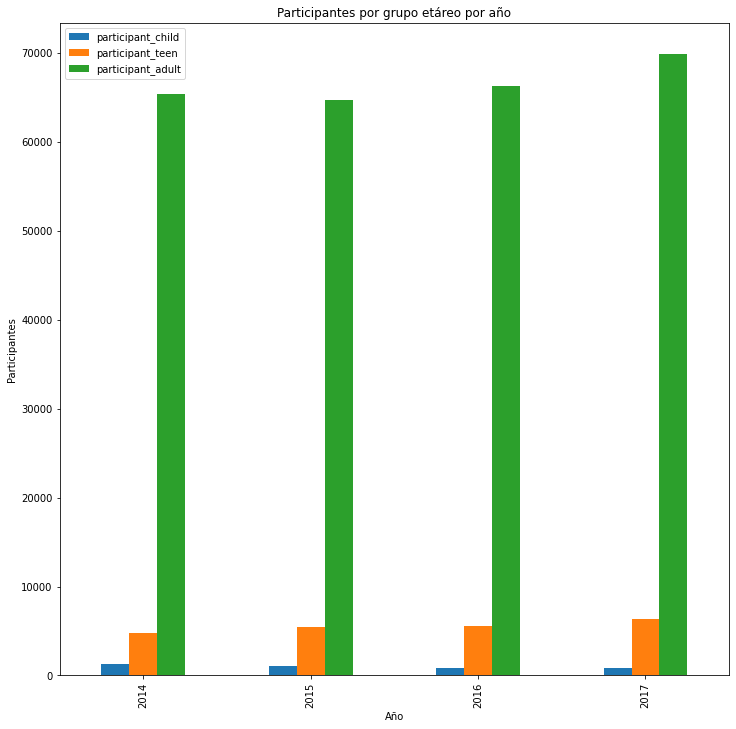

In [14]:
#participantes por grupo etáreo por año
gun_violence = gun_violence.reset_index(drop=True)
ge_año = gun_violence.groupby(['year']).sum()
ge_año[['participant_child','participant_teen','participant_adult']].plot.bar(figsize=(12, 12))
plt.xlabel('Año')
plt.ylabel('Participantes')
plt.title('Participantes por grupo etáreo por año')

Text(0.5, 1.0, 'Participantes por tipo por año')

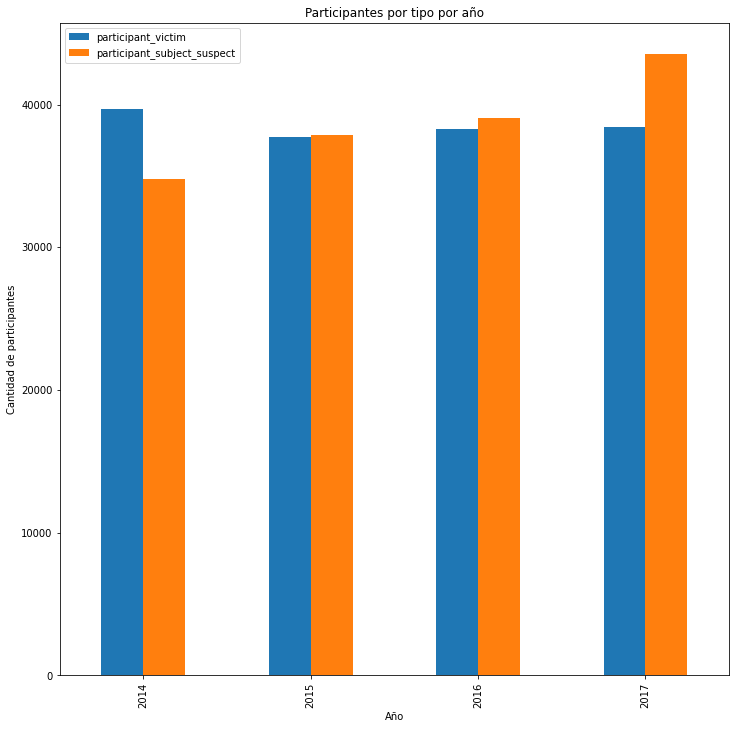

In [15]:
#participantes por tipo por año
gun_violence = gun_violence.reset_index(drop=True)
tipo_año = gun_violence.groupby(['year']).sum()
tipo_año[['participant_victim','participant_subject_suspect']].plot.bar(figsize=(12, 12))
plt.xlabel('Año')
plt.ylabel('Cantidad de participantes')
plt.title('Participantes por tipo por año')

Text(0.5, 1.0, 'Participantes por estado por año')

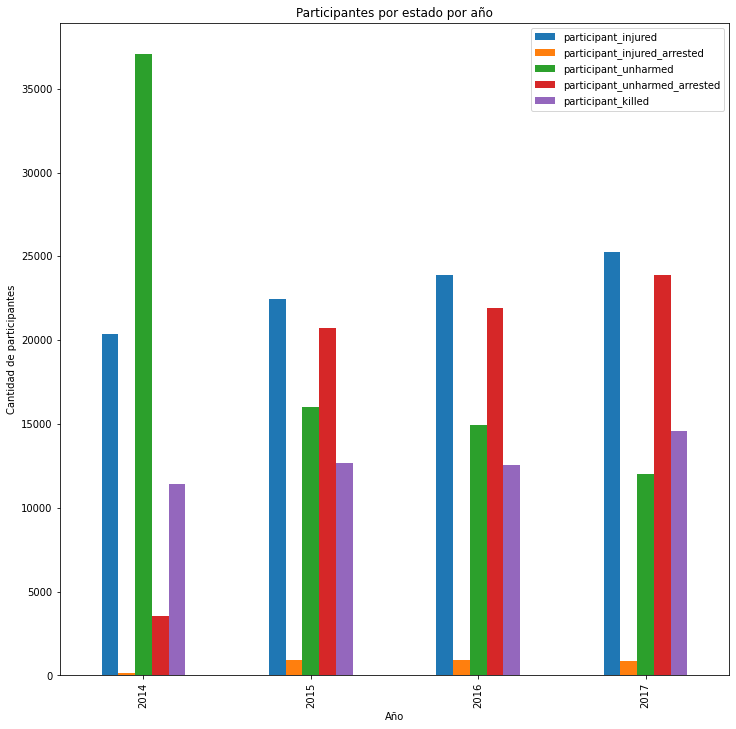

In [16]:
#participantes por status por año
gun_violence = gun_violence.reset_index(drop=True)
status_año = gun_violence.groupby(['year']).sum()
status_año[['participant_injured','participant_injured_arrested',	'participant_unharmed',	'participant_unharmed_arrested',	'participant_killed']].plot.bar(figsize=(12, 12))
plt.xlabel('Año')
plt.ylabel('Cantidad de participantes')
plt.title('Participantes por estado por año')

Text(0.5, 1.0, 'Participantes por grupo etáreo por estado')

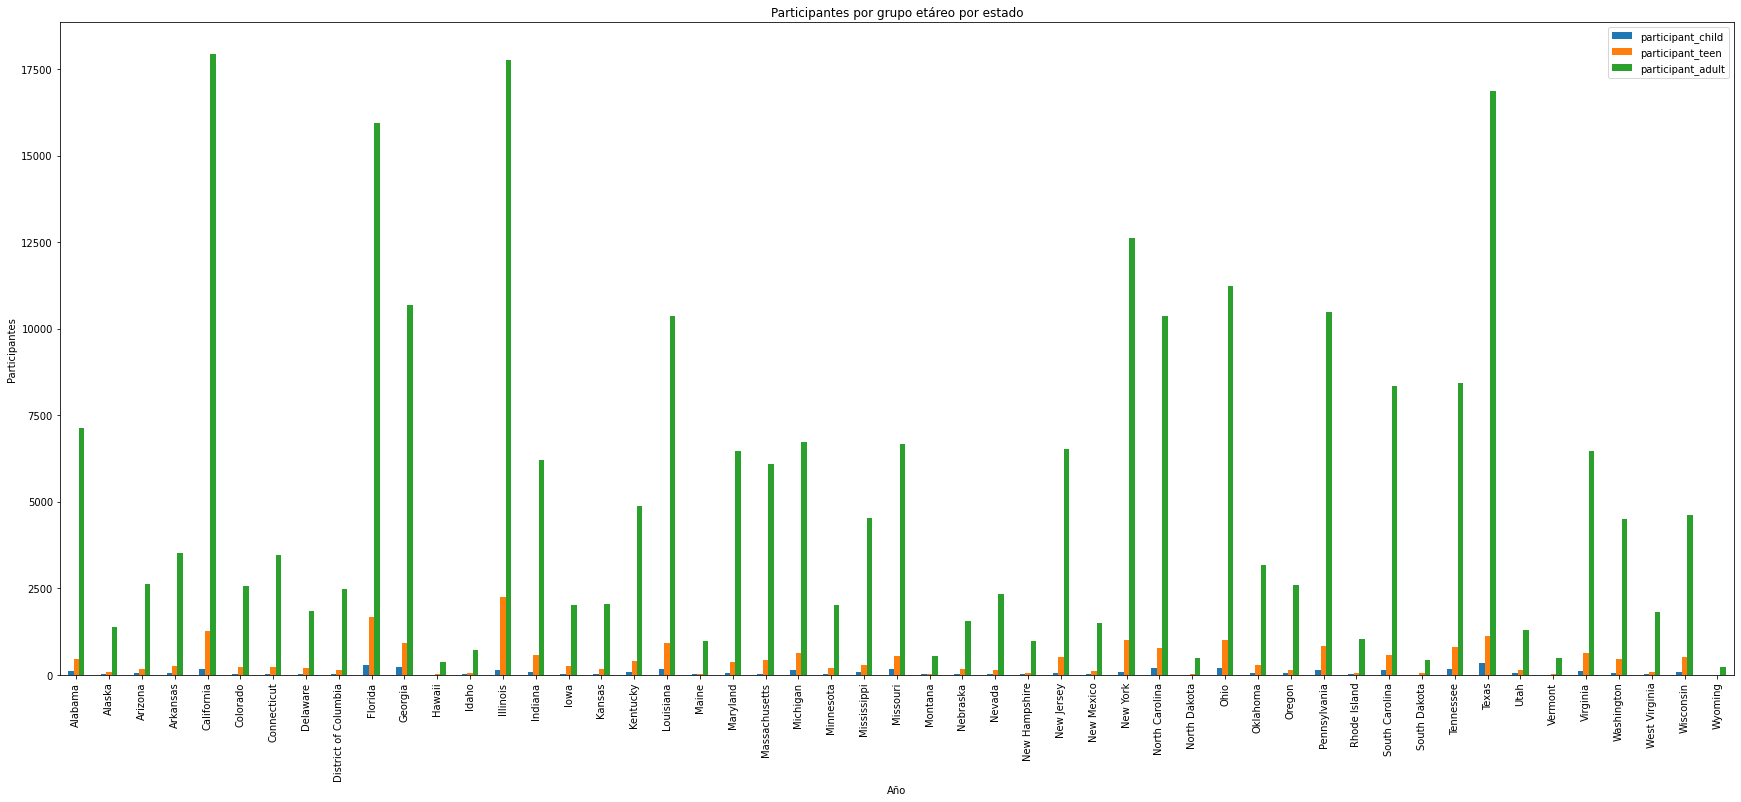

In [17]:
#participantes por grupo etáreo por estado
gun_violence = gun_violence.reset_index(drop=True)
ge_state = gun_violence.groupby(['state']).sum()
ge_state[['participant_child','participant_teen','participant_adult']].plot.bar(figsize=(30, 12))
plt.xlabel('Año')
plt.ylabel('Participantes')
plt.title('Participantes por grupo etáreo por estado')

Text(0.5, 1.0, 'Participantes por sexo por año')

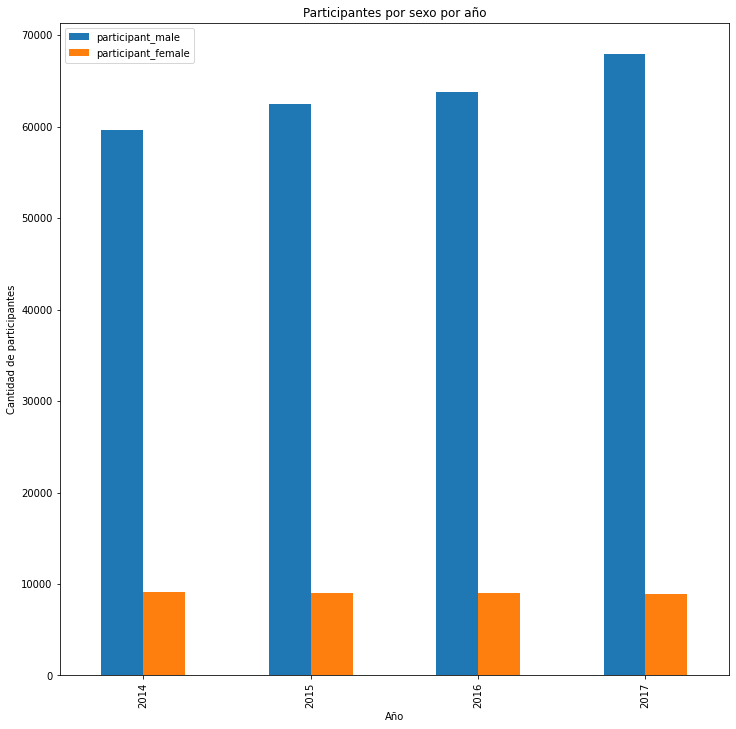

In [32]:
#participantes por sexo por año
gun_violence = gun_violence.reset_index(drop=True)
sexo_año = gun_violence.groupby(['year'])[['participant_male','participant_female']].sum()
sexo_año.plot.bar(figsize=(12, 12))
plt.xlabel('Año')
plt.ylabel('Cantidad de participantes')
plt.title('Participantes por sexo por año')

In [19]:
sexo_año[['participant_male','participant_female']]

participant_male      253815
participant_female     36019
dtype: int64

In [20]:
gun_violence[['participant_male', 'participant_female']].sum()

participant_male      253815
participant_female     36019
dtype: int64

Text(0.5, 1.0, 'Participantes por grupo etáreo por año')

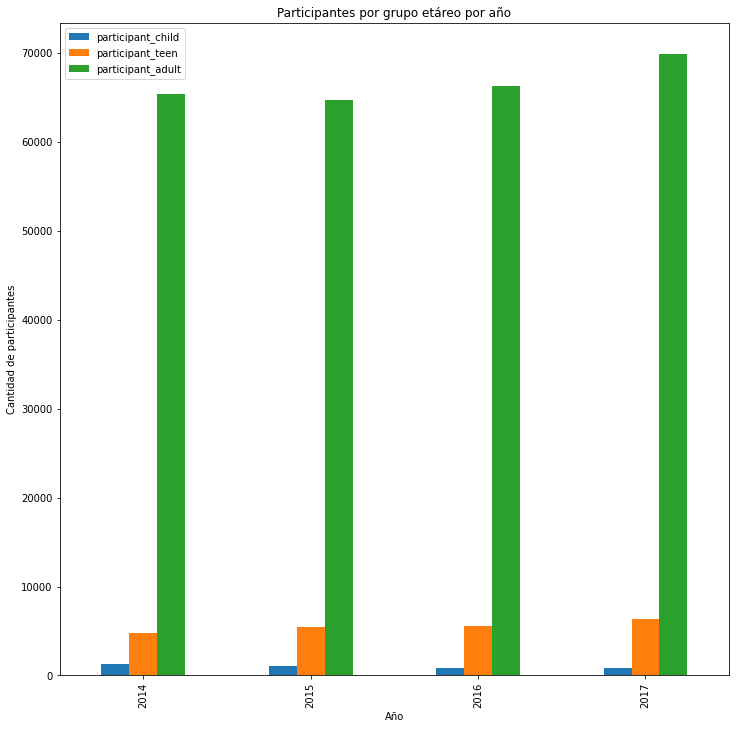

In [34]:
#participantes por edad por año
gun_violence = gun_violence.reset_index(drop=True)
sexo_año = gun_violence.groupby(['year'])[['participant_child','participant_teen','participant_adult']].sum()
sexo_año.plot.bar(figsize=(12, 12))
plt.xlabel('Año')
plt.ylabel('Cantidad de participantes')
plt.title('Participantes por grupo etáreo por año')

Text(0.5, 1.0, 'Muertos y heridos por mes')

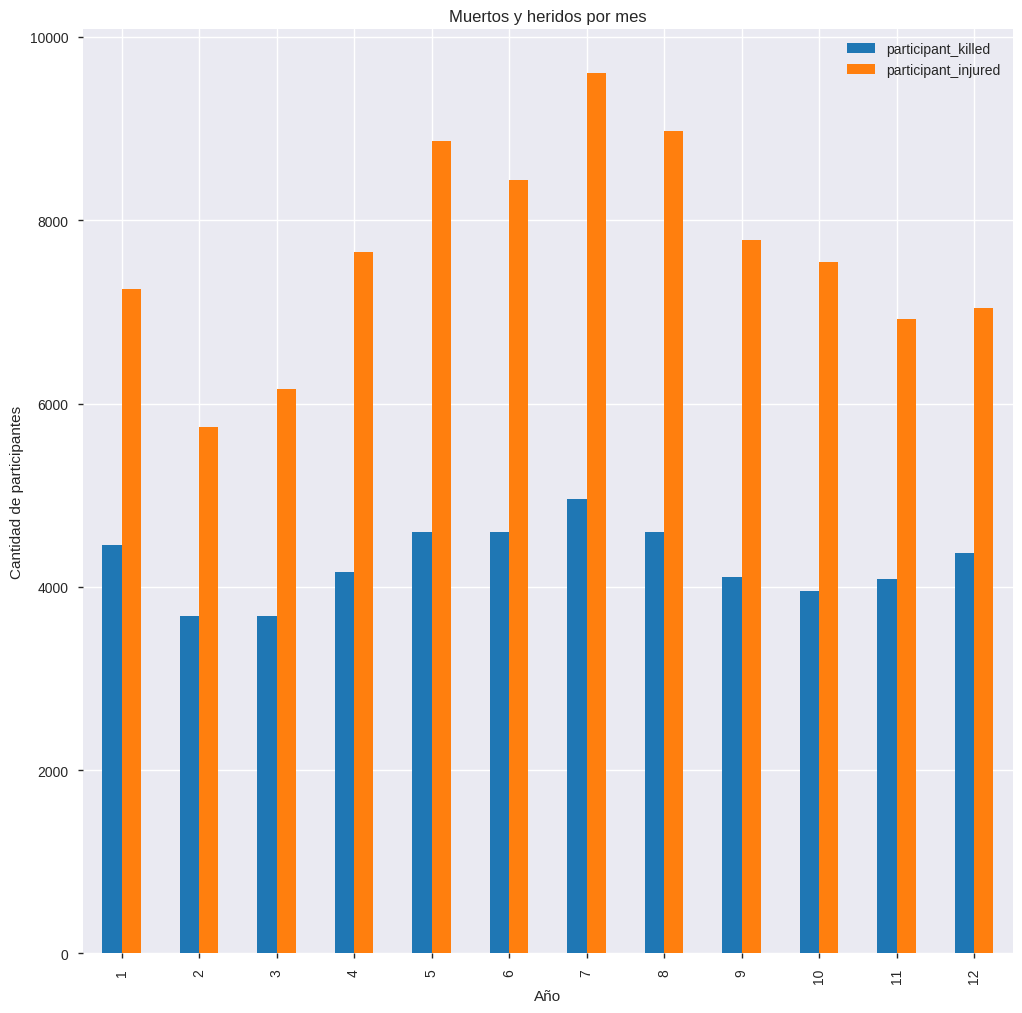

In [52]:
#muertos y heridos por mes
gun_violence = gun_violence.reset_index(drop=True)
sexo_año = gun_violence.groupby(['month'])[['participant_killed','participant_injured']].sum()
sexo_año.plot.bar(figsize=(12, 12))
plt.xlabel('Año')
plt.ylabel('Cantidad de participantes')
plt.title('Muertos y heridos por mes')

In [50]:
gun_violence.head()

,incident_id,date,state,city_or_county,n_killed,n_injured,gun_stolen,gun_type,incident_characteristics,latitude,...,participant_suspect_male,participant_suspect_female,participant_suspect_child,participant_suspect_teen,participant_suspect_adult,participant_suspect_injured,participant_suspect_injured_arrested,participant_suspect_unharmed,participant_suspect_unharmed_arrested,participant_suspect_killed
0,92114,2014-01-01,Kentucky,Lexington,0,1,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[Shot - Wounded/Injured],38.0507,...,0,0,0,0,0,0,0,0,0,0
1,92117,2014-01-01,Kentucky,Cynthiana,0,1,"[Unknown, None, None, None, None, None, None, ...","[Unknown, None, None, None, None, None, None, ...","[Shot - Wounded/Injured, Accidental Shooting, ...",38.4333,...,1,0,0,0,1,0,0,0,1,0
2,92119,2014-01-01,Kentucky,Louisville,0,1,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[Shot - Wounded/Injured],38.2501,...,0,0,0,0,0,0,0,0,0,0
3,92125,2014-01-01,Oklahoma,Lawton,0,0,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[Shots Fired - No Injuries],34.6347,...,1,0,0,0,0,0,0,1,0,0
4,92131,2014-01-01,New York,Bronx,0,1,"[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[Pistol-whipping],40.8179,...,0,0,0,0,0,0,0,0,0,0


# Probamos relaciones

Probando correlaciones mediante una matriz

In [23]:

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)


gun_aux = gun_violence.drop(['gun_type','latitude', 'incident_id', 'longitude', 'incident_characteristics', 'participant_male','participant_female', 'participant_child', 'participant_teen','participant_adult','participant_injured',
                             'participant_injured_arrested','participant_unharmed','participant_unharmed_arrested','participant_killed', 'participant_victim','participant_subject_suspect'], axis=1)
corr_matrix = gun_aux.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10000)


,variable_1,variable_2,r,abs_r
407,participant_victim_injured,n_injured,0.949106,0.949106
43,n_injured,participant_victim_injured,0.949106,0.949106
522,participant_victim_killed,n_killed,0.915605,0.915605
18,n_killed,participant_victim_killed,0.915605,0.915605
686,participant_suspect_adult,participant_suspect_male,0.810100,0.810100
...,...,...,...,...
336,participant_victim_child,participant_victim_unharmed_arrested,0.000105,0.000105
229,state_n,participant_suspect_unharmed,0.000079,0.000079
761,participant_suspect_unharmed,state_n,0.000079,0.000079
339,participant_victim_child,participant_suspect_female,-0.000072,0.000072


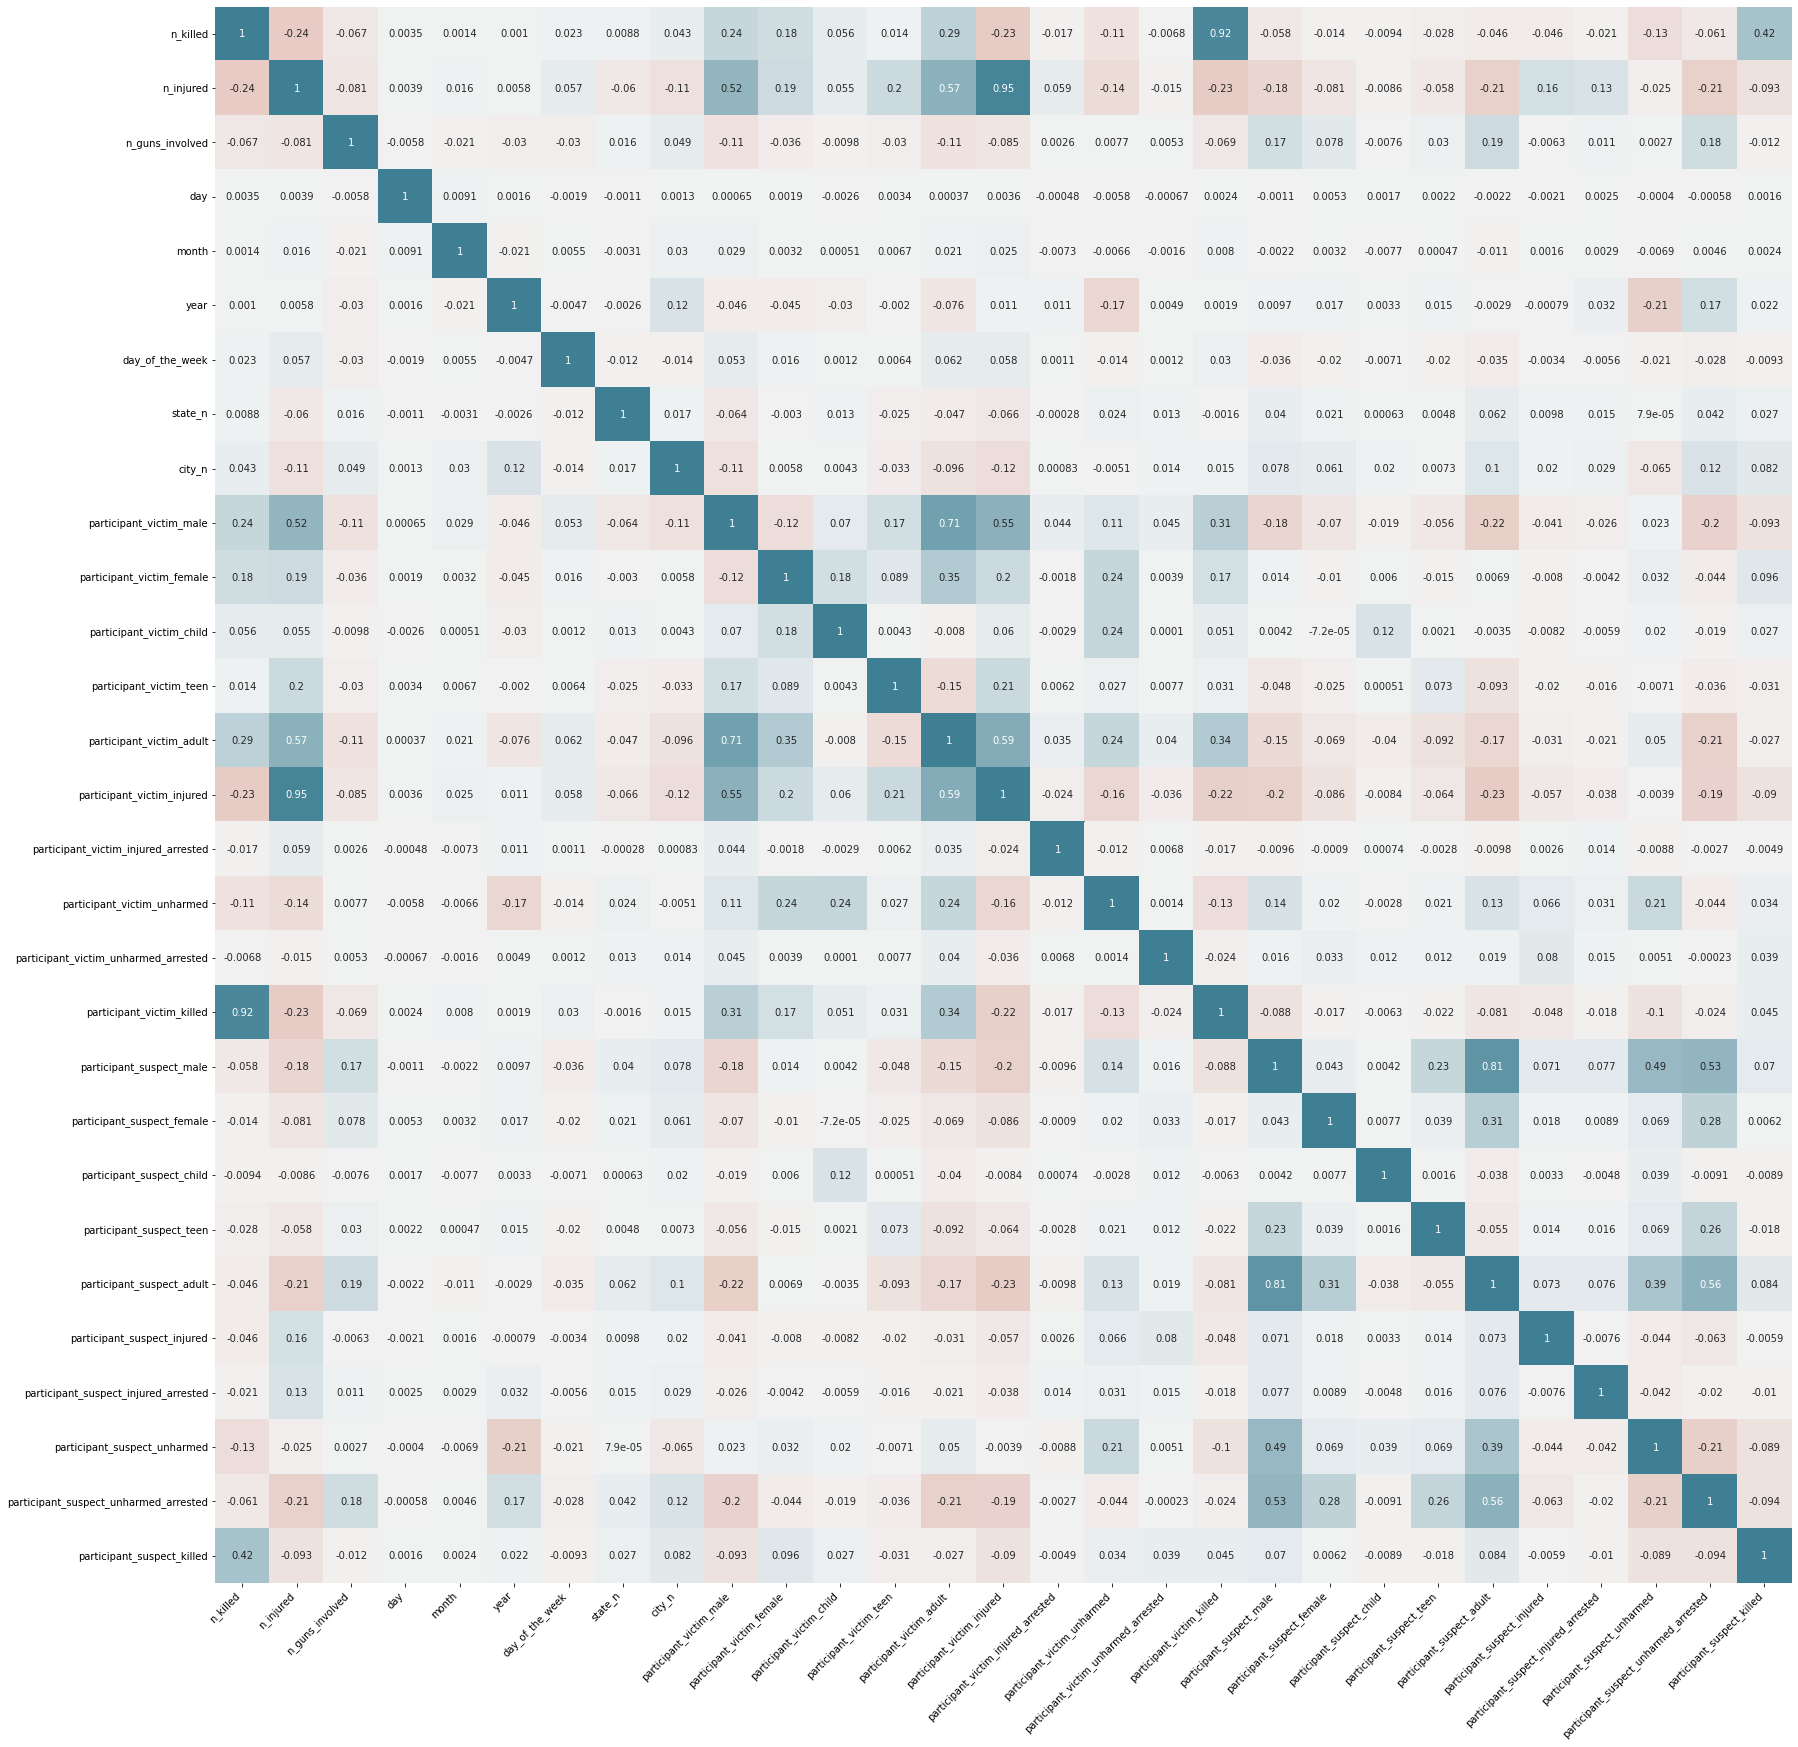

In [24]:
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(29, 29))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

In [ ]:
#revisar relacion victimas-heridos
#participant male - participant suspect
#participant male - adult
#participant suspect subject - participant_unharmed_arrested

#relacion muerto - victima
#relacion herido - victima
#victima masculino - victima adulta
#victima masculino - victima herida
#victima adulta - victima herida
#sospechoso masculino - sospechoso adulto
#sospechoso masulino - participante ileso
#sospechoso masulino - participante ileso arrestado
#sospechoso adulto - participante ileso arrestado

In [25]:
#Preparación de datos
y = gun_aux['participant_victim_injured']
X = gun_aux[['n_injured', 'participant_suspect_male', 'participant_suspect_adult']]

#Separacion en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Entrenamiento del modelo
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

#Realizando las predicciones
y_pred = regressor.predict(X_test).round(0)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)

from sklearn.metrics import r2_score, mean_absolute_error
#Con nuestro modelo
print("R2 Score:" + str(r2_score(y_test, y_pred)))
print("MAE:" + str(mean_absolute_error(y_test, y_pred)))

        Actual  Predicted
46279        0        1.0
130805       1        1.0
93490        0        0.0
127431       0        0.0
27732        0        0.0
...        ...        ...
168543       1        1.0
84573        0        0.0
18768        0        0.0
91751        0        0.0
113571       1        1.0

[34847 rows x 2 columns]
R2 Score:0.8851567877426808
MAE:0.04861250609808592


In [26]:
#Preparación de datos
y = gun_aux['participant_suspect_male']
X = gun_aux[['participant_suspect_adult', 'participant_suspect_unharmed_arrested']]

#Separacion en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Entrenamiento del modelo
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

#Realizando las predicciones
y_pred = regressor.predict(X_test).round(0)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)

from sklearn.metrics import r2_score, mean_absolute_error
#Con nuestro modelo
print("R2 Score:" + str(r2_score(y_test, y_pred)))
print("MAE:" + str(mean_absolute_error(y_test, y_pred)))

        Actual  Predicted
46279        1        1.0
130805       2        2.0
93490        1        1.0
127431       1        1.0
27732        2        2.0
...        ...        ...
168543       0        1.0
84573        0        0.0
18768        3        3.0
91751        1        2.0
113571       1        1.0

[34847 rows x 2 columns]
R2 Score:0.6579789794412573
MAE:0.1577467213820415


In [27]:
#Preparación de datos
y = gun_aux['participant_victim_killed']
X = gun_aux[['n_killed', 'participant_suspect_male', 'participant_suspect_adult']]

#Separacion en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Entrenamiento del modelo
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

#Realizando las predicciones
y_pred = regressor.predict(X_test).round(0)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)

from sklearn.metrics import r2_score, mean_absolute_error
#Con nuestro modelo
print("R2 Score:" + str(r2_score(y_test, y_pred)))
print("MAE:" + str(mean_absolute_error(y_test, y_pred)))

        Actual  Predicted
46279        0        0.0
130805       0        0.0
93490        0        0.0
127431       0        0.0
27732        0        0.0
...        ...        ...
168543       0        0.0
84573        1        1.0
18768        0        0.0
91751        0        0.0
113571       0        0.0

[34847 rows x 2 columns]
R2 Score:0.8284969376730598
MAE:0.03799466238126668


# Conclusiones del proyecto

Entendemos que las relaciones entre nuestras variables no son aún lo suficientemente lineales como para usar modelos de regresión, lo que implica que no hemos logrado predecir con precisión las variables objetivo.

Consideraremos como alternativa el uso de un modelo de clasificación a fin de lograr predecir categorías y elaborando nuevas hipótesis.

In [40]:
gun_violence['state_n'].describe()

count    174233.000000
mean         19.095849
std          12.755438
min           1.000000
25%           8.000000
50%          15.000000
75%          31.000000
max          51.000000
Name: state_n, dtype: float64

In [42]:
#pd.unique(gun_violence[['state']].values.ravel())

estados = gun_violence['state'].unique()
estados

x = np.array(estados)

def selection_sort(x):
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        (x[i], x[swap]) = (x[swap], x[i])
    return x

selection_sort(x)

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)